In [1]:
from spygrt.stream import Camera, DualCamera
from spygrt.tracker import Tracker
from spygrt.calibration import Calibrator
import open3d as o3d
import numpy as np
import pyrealsense2 as rs2
import time
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
cam = []
ctx = rs2.context()
a1=0
b1=0
for dev in ctx.query_devices():
    a1 = time.time()
    cam.append(Camera(dev))
    b1 = time.time()
    print(a1-b1)

-0.6599974632263184
-0.6391322612762451


In [3]:
d = DualCamera(cam[0],cam[1])

In [7]:
d.start_stream()

In [8]:
d.get_frames('o3d')

((Image[size={720,1280}, channels=1, UInt16, CUDA:0],
  Image[size={720,1280}, channels=3, UInt8, CUDA:0]),
 (Image[size={720,1280}, channels=1, UInt16, CUDA:0],
  Image[size={720,1280}, channels=3, UInt8, CUDA:0]))

In [6]:
d.timestamp

1683182978665.6768

In [6]:
d.compute_pcd()

PointCloud on CUDA:0 [1538892 points (Float32)].
Attributes: colors (dtype = Float32, shape = {1538892, 3}).

In [6]:
d.pose

(array([[ 0.86195683, -0.33138728,  0.38368335, -0.42744225],
        [-0.50618005, -0.60506707,  0.61455315, -0.41392866],
        [ 0.02849913, -0.72393119, -0.68928331,  0.49123943],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.81125468,  0.27118322, -0.5180015 ,  0.3853696 ],
        [ 0.57963234, -0.48931655,  0.65161008, -0.42114368],
        [-0.07676096, -0.82887208, -0.55414689,  0.49972939],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

In [9]:
calibs = (Calibrator(d.stream1), Calibrator(d.stream2))

In [22]:
for cal in calibs:
    cal._pose = o3d.core.Tensor(np.identity(4), dtype=o3d.core.Dtype.Float32,device=cal._stream.pcd.device)

In [23]:
for cal in calibs:
    cal.corners=[]
for i in range (100):
    d.get_frames('o3d')
    calibs[0].find_corners3d()
    calibs[1].find_corners3d()

In [24]:
#calibs[0].corners_scale()
#calibs[1].corners_scale()
calibs[0].align_cameras(calibs[1])
calibs[1].align_to_board(cal2 = calibs[0])

In [25]:
calfile = []
for cal in calibs:
    cal.write_cal(cal._stream.serial + "_calrefine.txt")
    calfile.append(cal._stream.serial + "_calrefine.txt")

In [26]:
d.load_calibration(calfile)

(array([[ 0.86299706, -0.33072573,  0.38191161, -0.42625722],
        [-0.50445729, -0.6053229 ,  0.61571658, -0.41517463],
        [ 0.02754653, -0.72401977, -0.68922889,  0.4914676 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.81114578,  0.27128857, -0.51811677,  0.38548806],
        [ 0.5798279 , -0.48881447,  0.65181285, -0.42139491],
        [-0.07643361, -0.82913381, -0.55380052,  0.49956444],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

In [14]:
for cal in calibs:
    cal.write_cal()

In [19]:
d.stream1._pose = calibs[0].pose.cpu().numpy()
d.stream2._pose = calibs[1].pose.cpu().numpy()

0.0049784183502197266


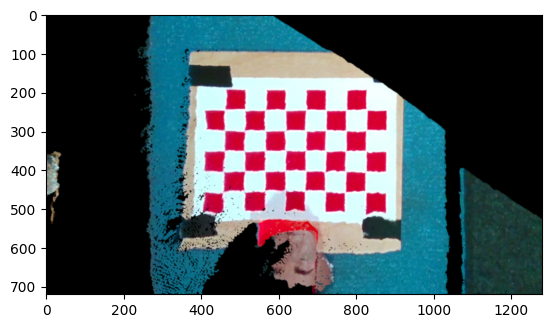

In [44]:

ext = o3d.core.Tensor(np.identity(4), dtype=o3d.core.Dtype.Float64, device=d.stream1.pcd.device)
ext[2][3] = 0.75
#ext[1][1] = -1
a1 = time.time()
rgbd = d.stream2.compute_pcd().project_to_rgbd_image(1280,720,d.stream1.intrinsics,ext)
print(time.time()-a1)
plt.imshow(rgbd.color.dilate(4).to_legacy(),interpolation='gaussian')
plt.show()

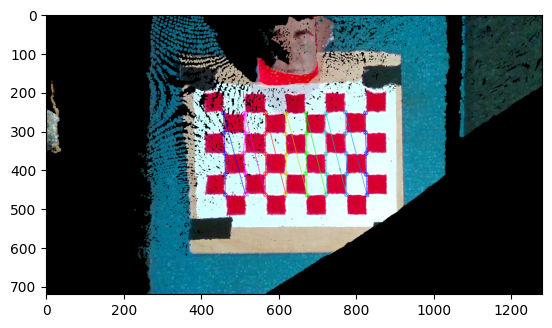

In [43]:
corners = np.asarray([])
color =(rgbd.color.dilate(4).as_tensor().cpu().numpy()*255).astype(np.uint8)
ret, corners = cv.findChessboardCorners(color, [5,8], corners,
                                                cv.CALIB_CB_FAST_CHECK)
plt.imshow(cv.drawChessboardCorners(color, [5, 8], corners, ret))
plt.show()

In [23]:
corners3d = []
for corner in corners:
    [u, v] = [int(np.rint(corner[0][1])), int(np.rint(corner[0][0]))]
    corners3d.append(d.stream1.intrinsics.inv() @ (
                    rgbd.depth.dilate(2).as_tensor()[u, v] * o3d.core.Tensor([u, v, 1], 
                                                                                dtype=o3d.core.Dtype.Float32, 
                                                                                device=rgbd.device) * 0.001).\
            to(dtype=o3d.core.Dtype.Float64))

TypeError: 'NoneType' object is not iterable

In [28]:
d.get_frames()
d.compute_pcd()
o3d.visualization.draw_geometries([d.pcd.to_legacy()])

In [21]:
x1 = calibs[0].pose
x2 = calibs[1].pose

In [25]:
x1

[[0.950468 -0.374075 -0.142162 -0.468783],
 [-0.118487 0.0868671 -1.02076 0.364629],
 [0.382234 0.957107 0.0370815 0.442535],
 [0.0 0.0 0.0 1.0]]
Tensor[shape={4, 4}, stride={4, 1}, Float32, CUDA:0, 0x1301194640]

In [33]:
np.append(calibs[0].avg_corners()[0],[1])

array([-0.02590478, -0.03748353,  0.75041999,  1.        ])

In [37]:
c=calibs[0].avg_corners().copy()
for i,corner in enumerate(calibs[0].avg_corners()):
    temp = np.append(corner, [1])
    c[i] = (calibs[0].pose.cpu().numpy()@temp)[0:3]

In [40]:
calibs[0].avg_corners()-c

array([[ 0.11923614, -0.12817979,  0.75760052],
       [ 0.11273381, -0.14162204,  0.77504727],
       [ 0.106177  , -0.15622511,  0.79064109],
       [ 0.09928559, -0.1707325 ,  0.80888711],
       [ 0.0932366 , -0.18435369,  0.82261414],
       [ 0.08561031, -0.20043889,  0.84314076],
       [ 0.07978201, -0.21369763,  0.85594324],
       [ 0.07262249, -0.22873448,  0.87496133],
       [ 0.13988727, -0.06137232,  0.73384979],
       [ 0.13469662, -0.07333436,  0.74444277],
       [ 0.12724801, -0.08892697,  0.76471645],
       [ 0.12072396, -0.10335371,  0.78045026],
       [ 0.11481299, -0.11622272,  0.79449737],
       [ 0.10656679, -0.13333183,  0.81771481],
       [ 0.09918751, -0.14908975,  0.83696909],
       [ 0.09569224, -0.15812214,  0.84075503],
       [ 0.16052238,  0.00531241,  0.71007046],
       [ 0.15528522, -0.0065293 ,  0.72116338],
       [ 0.14823482, -0.02165356,  0.73945005],
       [ 0.14161466, -0.03581839,  0.75628641],
       [ 0.13507156, -0.04996312,  0.772